Train Loss: 2.2211, Train Accuracy: 17.60%, Test Accuracy: 25.28%


Train Loss: 2.0575, Train Accuracy: 24.37%, Test Accuracy: 28.22%


Train Loss: 1.9491, Train Accuracy: 30.15%, Test Accuracy: 37.72%


Train Loss: 1.8100, Train Accuracy: 38.69%, Test Accuracy: 45.66%


Train Loss: 1.6274, Train Accuracy: 48.57%, Test Accuracy: 55.90%


Train Loss: 1.4399, Train Accuracy: 56.67%, Test Accuracy: 61.52%


Train Loss: 1.2823, Train Accuracy: 62.76%, Test Accuracy: 71.88%


Train Loss: 1.1423, Train Accuracy: 68.11%, Test Accuracy: 73.12%


Train Loss: 1.0191, Train Accuracy: 72.47%, Test Accuracy: 80.60%


Train Loss: 0.9083, Train Accuracy: 75.89%, Test Accuracy: 81.39%


Train Loss: 0.8078, Train Accuracy: 78.67%, Test Accuracy: 85.07%


Train Loss: 0.7212, Train Accuracy: 81.14%, Test Accuracy: 87.64%


Train Loss: 0.6517, Train Accuracy: 82.75%, Test Accuracy: 85.62%


Train Loss: 0.5864, Train Accuracy: 84.41%, Test Accuracy: 88.94%


Train Loss: 0.5461, Train Accuracy: 85.08%, Test Accuracy: 90.26%


Train Loss: 0.4963, Train Accuracy: 86.47%, Test Accuracy: 90.80%


Train Loss: 0.4624, Train Accuracy: 87.42%, Test Accuracy: 91.50%


Train Loss: 0.4256, Train Accuracy: 88.25%, Test Accuracy: 90.48%


Train Loss: 0.4063, Train Accuracy: 88.70%, Test Accuracy: 92.97%


Train Loss: 0.3782, Train Accuracy: 89.37%, Test Accuracy: 92.93%


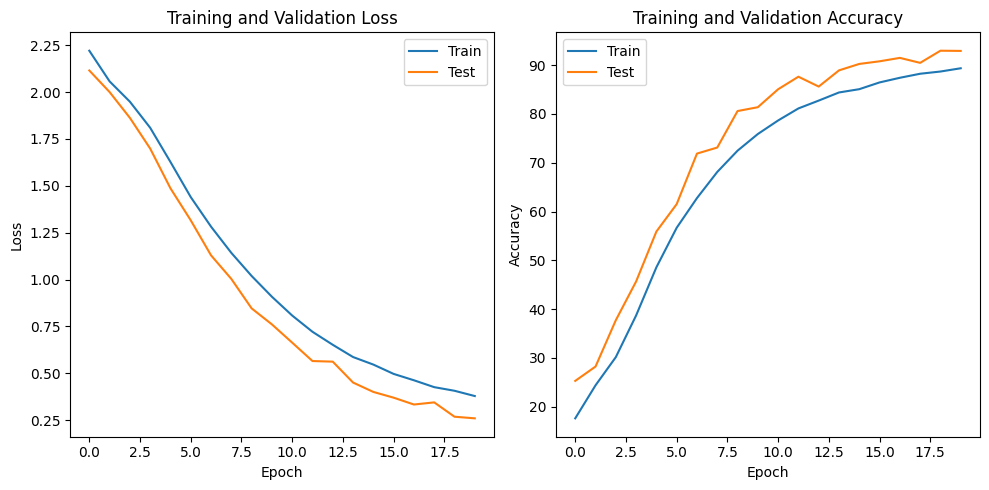

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define the Vision Transformer model with increased depth
class VisionTransformer(nn.Module):
    def __init__(self, image_size=32, patch_size=4, num_classes=10, dim=64, depth=12, heads=8, mlp_dim=128):
        super(VisionTransformer, self).__init__()
        num_patches = (image_size // patch_size) ** 2
        self.patch_size = patch_size

        self.patch_embedding = nn.Conv2d(1, dim, kernel_size=patch_size, stride=patch_size)
        self.positional_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))

        self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim), num_layers=depth)

        self.fc = nn.Linear(dim, num_classes)

    def forward(self, x):
        batch_size, _, _, _ = x.shape
        x = self.patch_embedding(x).flatten(2).transpose(1, 2)
        x = torch.cat([self.positional_embedding.repeat(batch_size, 1, 1), x], dim=1)
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

# Load and preprocess MNIST dataset with data augmentation
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data', train=True, download=True, transform=train_transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adjusted learning rate
criterion = nn.CrossEntropyLoss()

# Lists to store training and validation metrics
train_losses = []
train_accs = []
test_losses = []
test_accs = []

# Training loop
num_epochs = 20  # Increased number of epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    # Evaluation on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        running_loss = 0.0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_loss = running_loss / len(test_loader)
        test_accuracy = 100 * correct / total
        test_losses.append(test_loss)
        test_accs.append(test_accuracy)

    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

# Plotting the training and validation curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(test_accs, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
